<a href="https://colab.research.google.com/github/GulsumSayin/OSCC-Histopathology-Classification/blob/main/OSCC_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Gerekli Kütüphanelerin İmport Edilmesi

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

**Drive'a Bağlanma**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
import os
import numpy as np
import shutil
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 📁 Orijinal veri klasörü
original_dir = "/content/drive/MyDrive/datasets"  # İçerik: /normal, /oscc

# 🎯 Hedef sayılar
TARGET_COUNT = 1500

# 📁 Kayıt klasörü
augmented_dir = "/content/drive/MyDrive/augmented_balanced_data"
shutil.rmtree(augmented_dir, ignore_errors=True)  # Varsa sil

# 🔁 Augmenter (gerçek augmentasyon için)
augmenter = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

for cls in ['normal', 'oscc']:
    cls_dir = os.path.join(original_dir, cls)
    images = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    current_count = len(images)
    print(f"🔍 {cls} mevcut: {current_count}")

    # Kayıt klasörü oluştur
    save_cls_dir = os.path.join(augmented_dir, cls)
    os.makedirs(save_cls_dir, exist_ok=True)

    # Orijinalleri kopyala
    for img_name in images:
        shutil.copy(os.path.join(cls_dir, img_name), os.path.join(save_cls_dir, img_name))

    # Augmentasyon ile hedefe tamamla
    pbar = tqdm(total=TARGET_COUNT - current_count, desc=f"Augmenting {cls}")
    idx = 0
    aug_idx = 0
    while len(os.listdir(save_cls_dir)) < TARGET_COUNT:
        img_path = os.path.join(cls_dir, images[idx % current_count])
        try:
            img = tf.keras.utils.load_img(img_path)
            x = tf.keras.utils.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            aug_img = next(augmenter.flow(x, batch_size=1))[0].astype(np.uint8)
            save_name = f"aug_{aug_idx}_{os.path.basename(img_path)}"
            tf.keras.utils.save_img(os.path.join(save_cls_dir, save_name), aug_img)
            aug_idx += 1
            pbar.update(1)
        except Exception as e:
            print(f"⚠️ Hata: {e}")
        idx += 1
    pbar.close()

print("✅ Her sınıf için 1500 görüntüye ulaşan augmentasyon tamamlandı.")
"""

🔍 normal mevcut: 290


Augmenting normal:   0%|          | 0/1210 [00:00<?, ?it/s]

🔍 oscc mevcut: 934


Augmenting oscc:   0%|          | 0/566 [00:00<?, ?it/s]

✅ Her sınıf için 1500 görüntüye ulaşan augmentasyon tamamlandı.


In [ ]:
"""
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import os
import shutil

# 📁 Kaynak ve hedef klasör
input_dir = "/content/drive/MyDrive/augmented_balanced_data"
output_dir = "/content/drive/MyDrive/final_dataset"
shutil.rmtree(output_dir, ignore_errors=True)  # önce temizle

# 🖼️ Görselleri oku
image_paths = []
labels = []

for cls in os.listdir(input_dir):
    cls_path = os.path.join(input_dir, cls)
    for fname in os.listdir(cls_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(cls_path, fname))
            labels.append(cls.lower())

image_paths = np.array(image_paths)
labels = np.array(labels)

# 🔁 Stratified split: %80 train, %10 val, %10 test
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, temp_idx = next(sss1.split(image_paths, labels))

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(sss2.split(image_paths[temp_idx], labels[temp_idx]))

splits = {
    "train": (image_paths[train_idx], labels[train_idx]),
    "val": (image_paths[temp_idx][val_idx], labels[temp_idx][val_idx]),
    "test": (image_paths[temp_idx][test_idx], labels[temp_idx][test_idx]),
}

# 📁 Klasörleri oluştur ve dosyaları taşı
for split, (paths, split_labels) in splits.items():
    for path, label in zip(paths, split_labels):
        dst_dir = os.path.join(output_dir, split, label)
        os.makedirs(dst_dir, exist_ok=True)
        shutil.copy(path, os.path.join(dst_dir, os.path.basename(path)))

print("✅ Veri %80 train / %10 val / %10 test olarak başarıyla ayrıldı.")
"""

✅ Veri %80 train / %10 val / %10 test olarak başarıyla ayrıldı.


#### Veri Setinin Alınması

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 📁 Veri klasörleri
base_dir = "/content/drive/MyDrive/final_dataset"
train_dir = f"{base_dir}/train"
val_dir = f"{base_dir}/val"
test_dir = f"{base_dir}/test"

# 📐 Ayarlar
image_size = (224, 224)
batch_size = 32

# 🔁 Train için augmentasyon + normalizasyon
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# 🧪 Val ve test: sadece normalize
val_test_datagen = ImageDataGenerator(rescale=1./255)

# 🔽 Veri yükleyiciler
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Test için önemli
)

# 🧾 Kontrol
print("✅ Train sınıfları:", train_data.class_indices)
print("✅ Val sınıfları:", val_data.class_indices)
print("✅ Test sınıfları:", test_data.class_indices)

Found 2400 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
✅ Train sınıfları: {'normal': 0, 'oscc': 1}
✅ Val sınıfları: {'normal': 0, 'oscc': 1}
✅ Test sınıfları: {'normal': 0, 'oscc': 1}


#### Modelin Oluşturulması

In [ ]:
from tensorflow.keras.applications import InceptionV3

def build_inceptionv3(input_shape=(224, 224, 3)):
    base = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = True
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    return Model(base.input, output)

model = build_inceptionv3()
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,327,585 (85.17 MB)

 Trainable params: 22,293,153 (85.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

**Modelin Derlenmesi**

In [ ]:
from tensorflow.keras.optimizers import Adamax,Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(label_smoothing=0.05),  # 🔁 label smoothing eklenebilir
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ReduceLROnPlateau: val_loss durursa lr'i azalt
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Erken durdurma
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

callbacks = [early_stop]

#### Modelin Eğitilmesi

In [ ]:
history_1 = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 720s 8s/step - accuracy: 0.6486 - loss: 0.6337 - precision: 0.6523 - recall: 0.6456 - val_accuracy: 0.7067 - val_loss: 0.7902 - val_precision: 0.9559 - val_recall: 0.4333
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9000 - loss: 0.3212 - precision: 0.9010 - recall: 0.8966 - val_accuracy: 0.8167 - val_loss: 0.5411 - val_precision: 1.0000 - val_recall: 0.6333
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.9334 - loss: 0.2612 - precision: 0.9415 - recall: 0.9195 - val_accuracy: 0.9500 - val_loss: 0.2457 - val_precision: 0.9592 - val_recall: 0.9400
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.9551 - loss: 0.2219 - precision: 0.9540 - recall: 0.9547 - val_accuracy: 0.9633 - val_loss: 0.2003 - val_precision: 0.9793 - val_recall: 0.9467
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9615 - loss: 0.1950 - precision: 0.9605 - recall: 0.9654 - val_accuracy: 0.9600 - val_loss: 0.2110 

#### Eğitimin Görselleştirilmesi

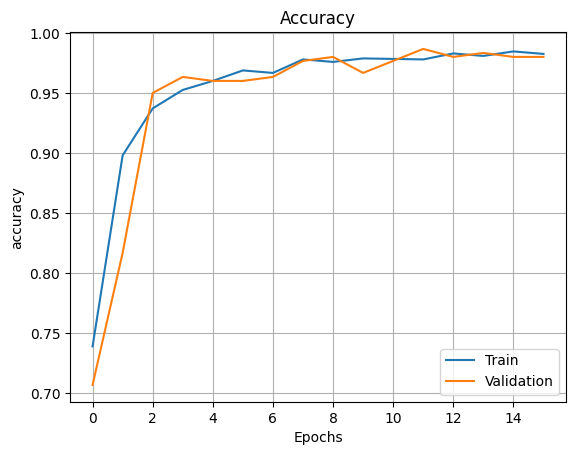

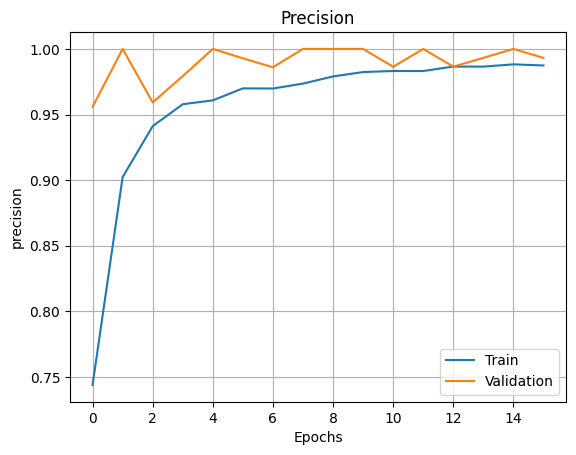

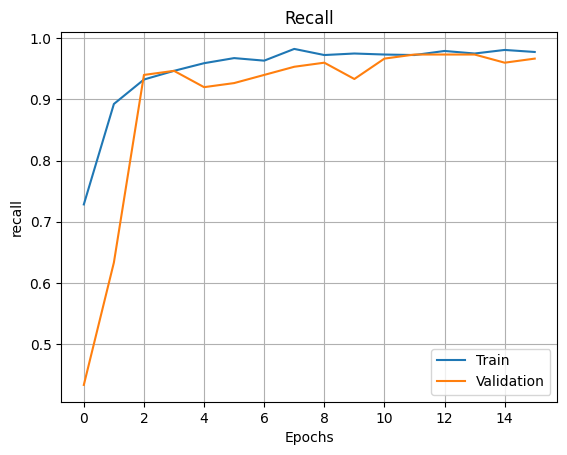

In [ ]:
# Eğitim metriklerini görselleştir
def plot_training(history):
    metrics = ['accuracy', 'precision', 'recall']
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history['val_' + metric], label='Validation')
        plt.title(metric.title())
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        plt.show()

plot_training(history_1)

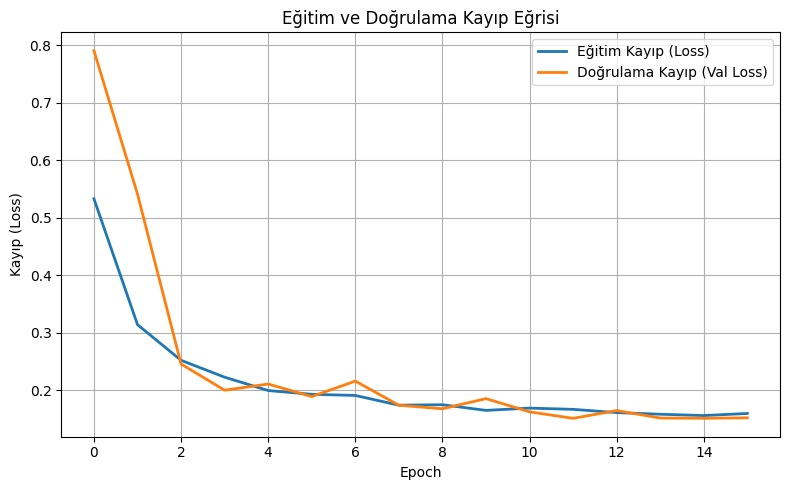

In [ ]:
def plot_loss_curves(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Eğitim Kayıp (Loss)', linewidth=2)
    plt.plot(history.history['val_loss'], label='Doğrulama Kayıp (Val Loss)', linewidth=2)
    plt.title('Eğitim ve Doğrulama Kayıp Eğrisi')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp (Loss)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_loss_curves(history_1)

### Modelin Test Edilmesi

In [ ]:
from sklearn.metrics import roc_curve

y_pred_prob = model.predict(test_data)
y_true = test_data.classes

# ROC eğrisini hesapla
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold:", optimal_threshold)

# Yeni tahminler
y_pred = (y_pred_prob > optimal_threshold).astype(int)

10/10 ━━━━━━━━━━━━━━━━━━━━ 98s 10s/step
Optimal threshold: 0.4745129


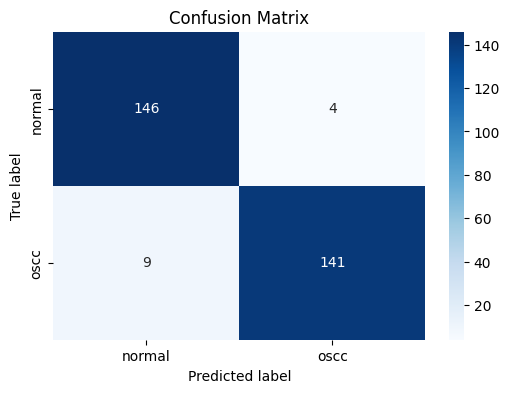

=== Classification Report ===
              precision    recall  f1-score   support

      normal       0.94      0.97      0.96       150
        oscc       0.97      0.94      0.96       150

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix hesapla
cm = confusion_matrix(y_true, y_pred)

# Sınıf isimlerini test_data’dan al (0: Normal, 1: OSCC gibi)
class_names = list(test_data.class_indices.keys())

# Görselleştir
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Classification raporu
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

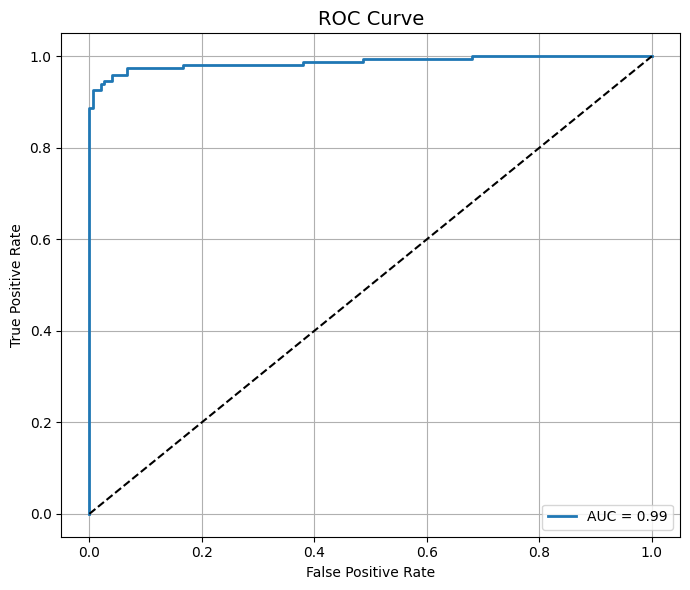

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", linewidth=2)
plt.plot([0,1], [0,1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve", fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import cohen_kappa_score

In [ ]:
kappa = cohen_kappa_score(y_true, y_pred)
print("Cohen's Kappa Skoru:", kappa)

Cohen's Kappa Skoru: 0.9133333333333333


**Modelin Kaydedilmesi**

In [ ]:
model.save('/content/drive/MyDrive/inceptionv3_model.keras')

#### Grad CAM

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# --- Son 4D (H,W,C) katmanı otomatik bulucu ---
def suggest_last_4d_layer(model):
    for layer in reversed(model.layers):
        try:
            shp = getattr(layer, "output", None).shape
            if shp is not None and len(shp) == 4:
                return layer.name
        except Exception:
            pass
    return None

def _get_target_layer(model, preferred=None, fallbacks=None):
    # 1) tercih edilen isim
    if preferred is not None:
        try:
            model.get_layer(preferred)
            return preferred
        except Exception:
            pass
    # 2) fallback adaylar
    if fallbacks:
        for name in fallbacks:
            try:
                model.get_layer(name)
                return name
            except Exception:
                continue
    # 3) otomatik son 4D
    auto = suggest_last_4d_layer(model)
    if auto is None:
        raise ValueError("Uygun 4D katman bulunamadı; lütfen last_conv_layer_name verin.")
    return auto

def make_gradcam_heatmap(img_array, model, last_conv_layer_name=None):
    """
    img_array: (1,H,W,3) float32, modelin eğitimine uygun ölçek (örn. /255 veya preprocess_input)
    model: InceptionV3 tabanlı binary model (sigmoid, 1 nöron)
    last_conv_layer_name: None ise 'mixed10' -> fallback -> otomatik
    """
    # InceptionV3 için iyi adaylar:
    target_name = _get_target_layer(
        model,
        preferred=(last_conv_layer_name or "mixed10"),
        fallbacks=["conv2d_94", "conv2d_93", "mixed9"]
    )
    last_conv_layer = model.get_layer(target_name)

    # Son konv çıktısı + model çıkışı veren model (tekil tensörler!)
    grad_model = tf.keras.Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array, training=False)
        if isinstance(preds, (list, tuple)):
            preds = preds[0]
        preds = tf.convert_to_tensor(preds)
        # Binary -> tek nöron
        class_channel = preds[:, 0]
        grads = tape.gradient(class_channel, conv_outputs)

    # Kanal başına global ortalama (Grad‑CAM ağırlıkları)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # (C,)
    conv_outputs = conv_outputs[0]                        # (H,W,C)

    # Ağırlıkları uygula → ReLU → normalize
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-12)
    return heatmap.numpy(), target_name

def display_gradcam(img_path, model, last_conv_layer_name=None, alpha=0.5,
                    target_size=(224,224), use_preprocess=False):
    """
    use_preprocess=False: eğitimde /255 kullandıysan
    use_preprocess=True : eğitimde inception_v3.preprocess_input kullandıysan
    """
    # 1) Görseli yükle
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    arr = tf.keras.utils.img_to_array(img)  # float32 [0..255]
    arr_batch = np.expand_dims(arr, axis=0)

    # 2) Eğitimle uyumlu ölçekleme
    if use_preprocess:
        from tensorflow.keras.applications.inception_v3 import preprocess_input
        arr_in = preprocess_input(arr_batch.copy())
    else:
        arr_in = arr_batch / 255.0

    # 3) Isı haritası
    heatmap, used_layer = make_gradcam_heatmap(arr_in, model, last_conv_layer_name)

    # 4) Orijinal üzerine bindirme
    img_cv = cv2.imread(img_path)
    img_cv = cv2.resize(img_cv, (target_size[1], target_size[0]))
    heatmap_resized = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_cv, 1 - alpha, heatmap_colored, alpha, 0)

    # 5) Göster
    plt.figure(figsize=(10, 4))
    plt.suptitle(f"Grad-CAM (layer: {used_layer})", y=1.02)
    plt.subplot(1,3,1); plt.title("Original");     plt.imshow(img_cv[..., ::-1]); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Grad-CAM");     plt.imshow(heatmap, cmap="jet"); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Superimposed"); plt.imshow(superimposed[..., ::-1]); plt.axis("off")
    plt.tight_layout(); plt.show()

    return used_layer  # hangi katmanı kullandığını görmek istersen

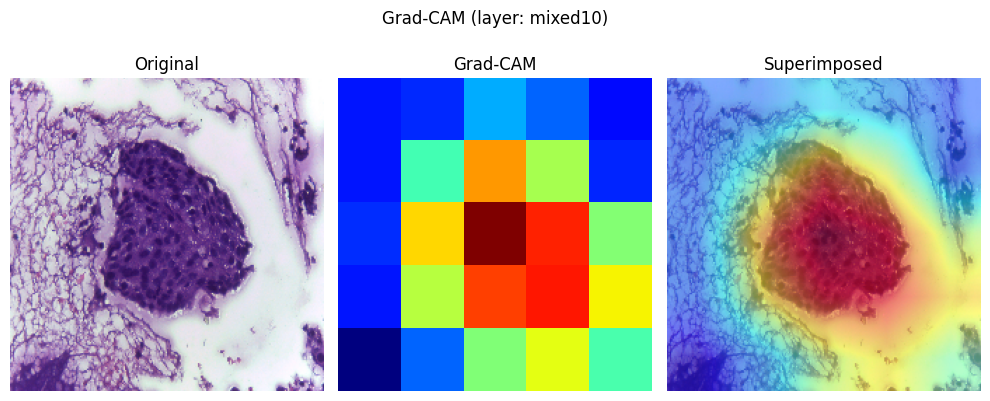

Used layer: mixed10


In [ ]:
img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_495.jpg"

used = display_gradcam(img_path, model, last_conv_layer_name="mixed10",
                       alpha=0.5, target_size=(224,224), use_preprocess=False)
print("Used layer:", used)

#### Integrated Gradients

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


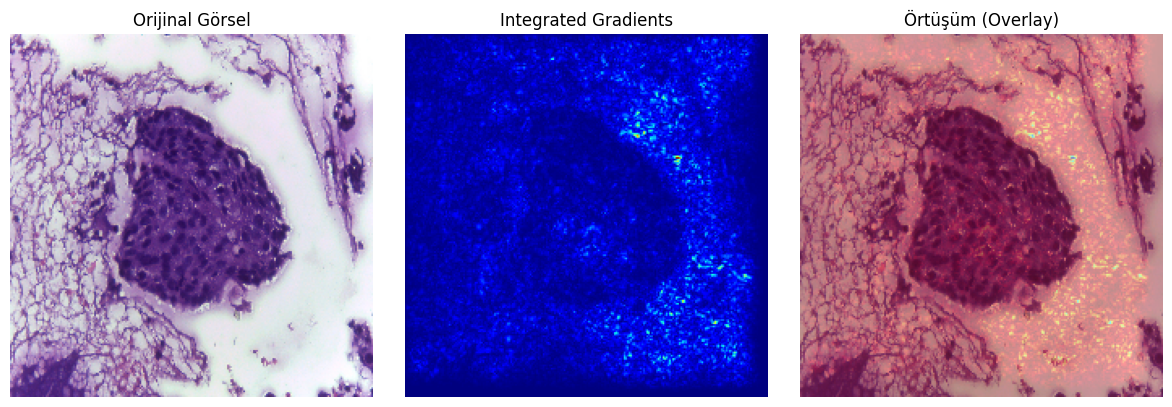

In [ ]:
# 🔧 Gerekli kütüphaneler
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# 📷 Görseli yükle ve ön işle
img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_495.jpg" # test görselin
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0) / 255.0  # normalize

# 🎯 Hedef sınıfı al (tahmin edilen sınıf)
preds = model.predict(img_batch)
target_class_idx = int(np.round(preds[0][0]))  # sigmoid olduğu için 0 veya 1

# 🔁 Integrated Gradients fonksiyonları
@tf.function
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    delta = image - baseline
    images = baseline + alphas_x * delta
    return images

@tf.function
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        output = preds[:, 0]  # sigmoid tek çıktı
    grads = tape.gradient(output, images)
    return grads

def integrated_gradients(baseline, image, target_class_idx, m_steps=50):
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps)
    interpolated = interpolate_images(baseline, image, alphas)
    grads = compute_gradients(interpolated, target_class_idx)
    avg_grads = tf.reduce_mean(grads, axis=0).numpy()
    delta = (image - baseline).numpy()[0]
    integrated_grads = delta * avg_grads
    return integrated_grads

# 🚫 Sıfır referans (siyah görüntü)
baseline = tf.zeros(shape=(1, 224, 224, 3))

# 📈 Integrated Gradients hesapla
ig = integrated_gradients(baseline, tf.convert_to_tensor(img_batch), target_class_idx)

# 🎨 Normalize et
attribution = np.mean(np.abs(ig), axis=-1)
attribution -= attribution.min()
attribution /= attribution.max()

# 🖼️ Görselleştir
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.array(img).astype(np.uint8))
axs[0].set_title("Orijinal Görsel")
axs[0].axis("off")

axs[1].imshow(attribution, cmap='jet')
axs[1].set_title("Integrated Gradients")
axs[1].axis("off")

heatmap = cv2.applyColorMap(np.uint8(255 * attribution), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(np.array(img).astype(np.uint8), 0.6, heatmap, 0.4, 0)
axs[2].imshow(overlay)
axs[2].set_title("Örtüşüm (Overlay)")
axs[2].axis("off")

plt.tight_layout()
plt.show()

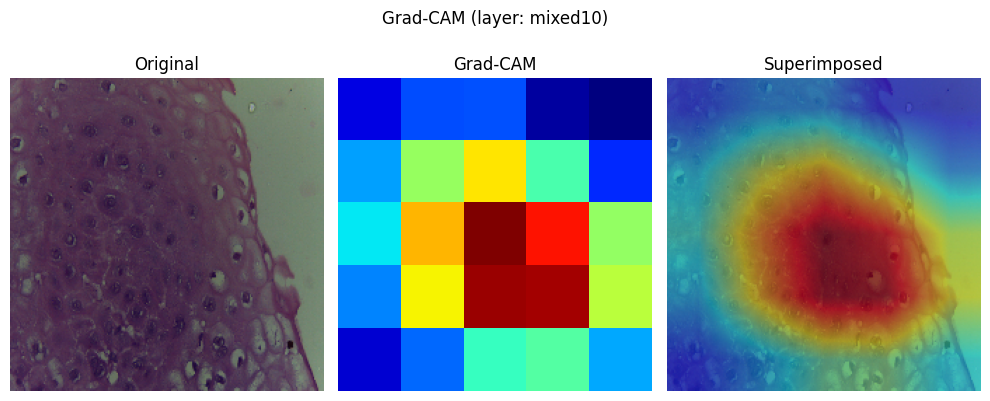

Used layer: mixed10


In [ ]:
img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_494.jpg"

# Eğitimde /255 kullandıysan:
used = display_gradcam(img_path, model, last_conv_layer_name="mixed10",
                       alpha=0.5, target_size=(224,224), use_preprocess=False)
print("Used layer:", used)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


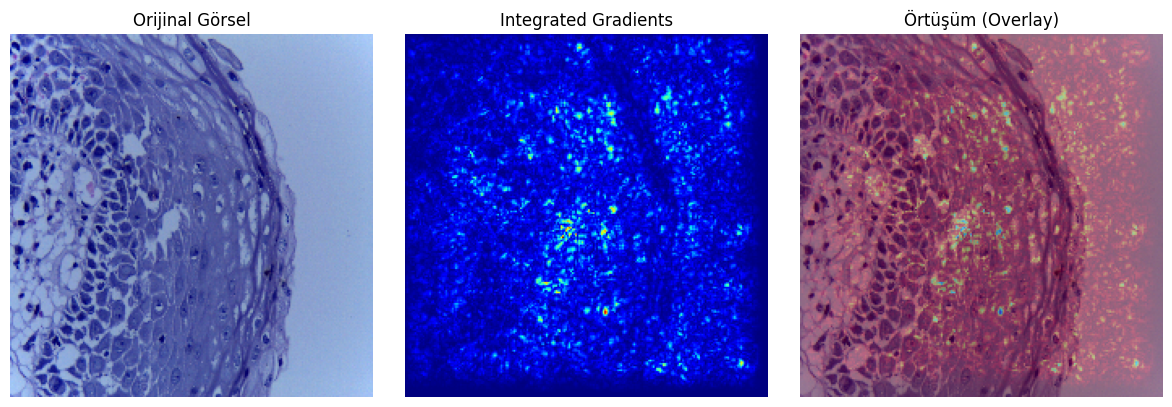

In [ ]:
# 🔧 Gerekli kütüphaneler
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# 📷 Görseli yükle ve ön işle
img_path = "/content/drive/MyDrive/final_dataset/train/normal/Normal_400x_193.jpg"# test görselin
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0) / 255.0  # normalize

# 🎯 Hedef sınıfı al (tahmin edilen sınıf)
preds = model.predict(img_batch)
target_class_idx = int(np.round(preds[0][0]))  # sigmoid olduğu için 0 veya 1

# 🔁 Integrated Gradients fonksiyonları
@tf.function
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    delta = image - baseline
    images = baseline + alphas_x * delta
    return images

@tf.function
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        output = preds[:, 0]  # sigmoid tek çıktı
    grads = tape.gradient(output, images)
    return grads

def integrated_gradients(baseline, image, target_class_idx, m_steps=50):
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps)
    interpolated = interpolate_images(baseline, image, alphas)
    grads = compute_gradients(interpolated, target_class_idx)
    avg_grads = tf.reduce_mean(grads, axis=0).numpy()
    delta = (image - baseline).numpy()[0]
    integrated_grads = delta * avg_grads
    return integrated_grads

# 🚫 Sıfır referans (siyah görüntü)
baseline = tf.zeros(shape=(1, 224, 224, 3))

# 📈 Integrated Gradients hesapla
ig = integrated_gradients(baseline, tf.convert_to_tensor(img_batch), target_class_idx)

# 🎨 Normalize et
attribution = np.mean(np.abs(ig), axis=-1)
attribution -= attribution.min()
attribution /= attribution.max()

# 🖼️ Görselleştir
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.array(img).astype(np.uint8))
axs[0].set_title("Orijinal Görsel")
axs[0].axis("off")

axs[1].imshow(attribution, cmap='jet')
axs[1].set_title("Integrated Gradients")
axs[1].axis("off")

heatmap = cv2.applyColorMap(np.uint8(255 * attribution), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(np.array(img).astype(np.uint8), 0.6, heatmap, 0.4, 0)
axs[2].imshow(overlay)
axs[2].set_title("Örtüşüm (Overlay)")
axs[2].axis("off")

plt.tight_layout()
plt.show()

**Modelin Yüklenmesi**

In [ ]:
model=tf.keras.models.load_model("/content/drive/MyDrive/inceptionv3_model.keras")

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

#img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_495.jpg"  # örnek yol
#img_path="/content/drive/MyDrive/final_dataset/train/normal/Normal_400x_193.jpg"
img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_468.jpg"

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # (1, 224, 224, 3)
img_array = img_array / 255.0  # Normalize

In [ ]:
pred_prob = model.predict(img_array)[0][0]

threshold = optimal_threshold  # veya ROC ile optimize ettiğin değer
pred_label = "OSCC" if pred_prob > threshold else "Normal"

print(f"Model çıktısı (olasılık): {pred_prob:.4f}")
print(f"Tahmin edilen sınıf: {pred_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Model çıktısı (olasılık): 0.9885
Tahmin edilen sınıf: OSCC


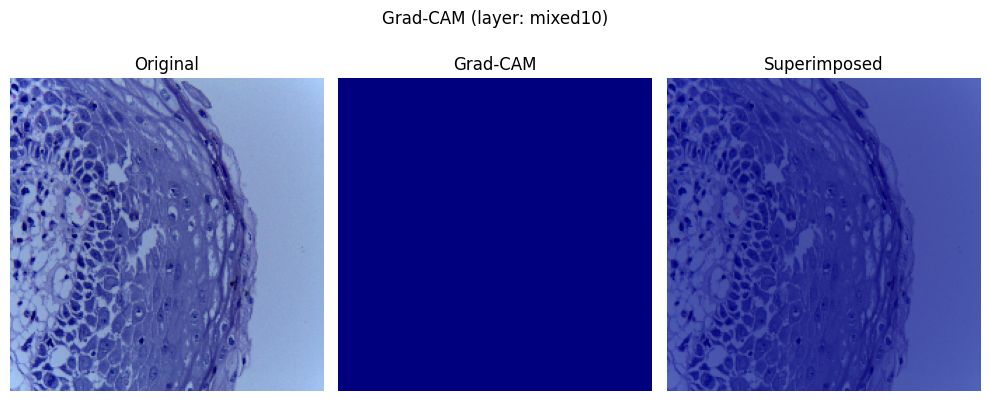

Used layer: mixed10


In [ ]:
img_path = "/content/drive/MyDrive/final_dataset/train/normal/Normal_400x_193.jpg"
# Eğitimde /255 kullandıysan:
used = display_gradcam(img_path, model, last_conv_layer_name="mixed10",
                       alpha=0.5, target_size=(224,224), use_preprocess=False)
print("Used layer:", used)